array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [222., 222., 222.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

1/1 [==============================] - 0s 170ms/step
[[ 5.223418 -5.294072]]


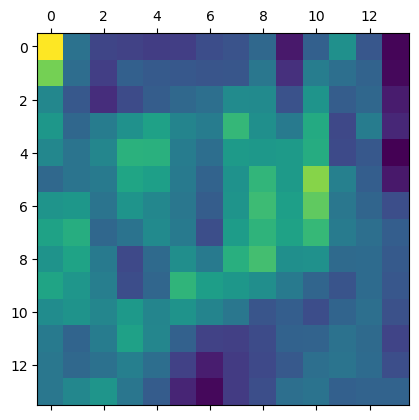

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
  
    # `img` is a PIL image
    img = keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (w, h, 3)
    array = keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, x, y, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, 
                         model, 
                         last_layer_before_inner='tf.nn.bias_add', 
                         inner_model='vgg16', 
                         inner_conv_layer='block5_conv3', 
                         normalize=False):
  
    # Preprocess the image array
    before_inner = keras.Model([model.inputs], [model.get_layer(last_layer_before_inner).output])
    img_array = before_inner(img_array)

    # Extract the inner model out of the nested model
    inner = keras.Model([model.get_layer(inner_model).inputs], [model.get_layer(inner_model).output])

    # Reconstruct the downstream model
    if 'global_average_pooling2d' in [layer.name for layer in model.layers]:
        pooling = model.get_layer('global_average_pooling2d')(inner.output)
    else:
        pooling = model.get_layer('global_max_pooling2d')(inner.output)
    dense = model.get_layer('dense')(pooling)
    batch_normalization = model.get_layer('batch_normalization')(dense)
    dropout = model.get_layer('dropout')(batch_normalization)
    activation = model.get_layer('activation')(dropout)
    output = model.get_layer('dense_1')(activation)

    # New a model with both the layer and the final output as the outputs
    grad_model = keras.Model([inner.inputs], [inner.get_layer(inner_conv_layer).output, output])

    # Plot the model map if needed
    # tf.keras.utils.plot_model(grad_model, show_shapes=True, show_dtype=True)
    
    all_heatmaps = []
    
    # Compute the gradient of each of the predicted class for our input image
    # with respect to the activations of the last conv layer
    for pred_index in range(output.shape[1]):
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            class_channel = preds[:, pred_index]
        
        # Compute the gradient of the output neuron (single class) with regard to the output
        # feature map of the last conv layer. (1, 14, 14, 512)
        grads = tape.gradient(class_channel, last_conv_layer_output)
        
        # The is a vector where each entry is the mean intensity of the
        # gradient over a specific feature map channel. (512, )
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Reduce to a 3D tensor
        last_conv_layer_output = last_conv_layer_output[0]
        
        # Multiply each channel in the feature map array by
        # "how important" this channel is" with regard to the 
        # selected class, then sum all the channels to obtain the 
        #  heatmap class activation.
        # (14, 14, 512) %*% (512, 1) -> (14, 14, 1)
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        
        # Reduce to a 2D tensor
        # (14, 14, 1) -> (14, 14)
        heatmap = tf.squeeze(heatmap)
        
        # Normalize the heatmap if needed
        if normalize:
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        # Convert it back to a numpy array (easier to work with) 
        #  and store in a list
        all_heatmaps.append(heatmap.numpy())
        
    return all_heatmaps

img_size = (224, 224)
plot_id = '110.png'
img = get_img_array(f"/Users/patrickli/Desktop/rproject/automatic_visual_inference/data/single_plot_null_or_not_sim_only/mixed/test/not_null/{plot_id}", 
                    img_size)
                    
display(img)

# Make model
model = keras.models.load_model("/Users/patrickli/Desktop/rproject/automatic_visual_inference/models/single_plot_null_or_not_sim_only/mixed")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the predictions are
preds = model.predict(img)
print(preds)

# Generate class activation heatmap
heatmaps = make_gradcam_heatmap(img, model)

# Display heatmap
plt.matshow(heatmaps[0])
plt.show()


/var/folders/61/bv7_1qzs20x6fjb2rsv7513r0000gn/T/ipykernel_92572/3601248576.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


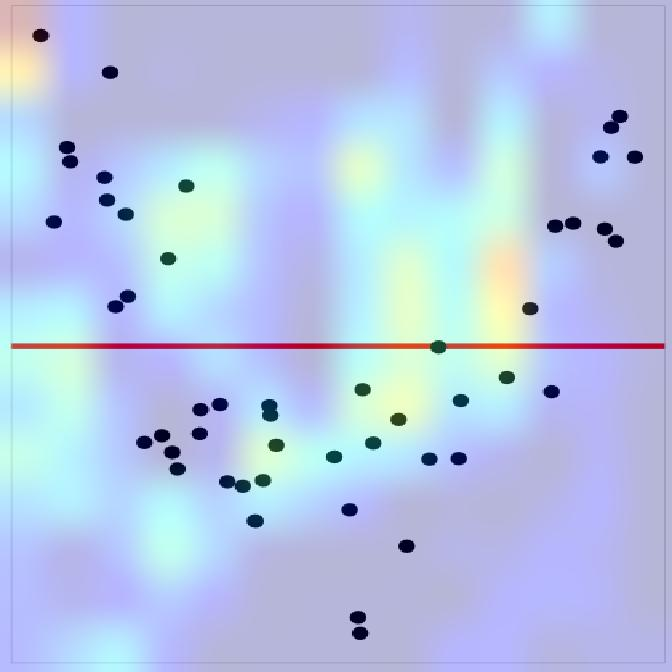

In [75]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path, target_size=(224 * 3, 224 * 3))
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(f"/Users/patrickli/Desktop/rproject/automatic_visual_inference/data/single_plot_null_or_not_sim_only/mixed/test/not_null/{plot_id}", heatmap)